In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd
import geemap



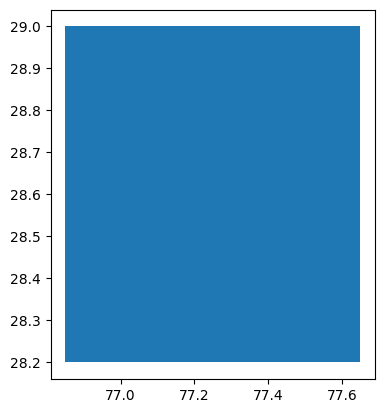

In [ ]:
shapefile_path = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/delhi_airshed.geojson'
gdf = gpd.read_file(shapefile_path)
gdf.plot()
plt.show()

In [ ]:
kilns_dir = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/after_hand_validation_data/gdf_kilns_new.csv'
kilns_gdf = gpd.read_file(kilns_dir)
print(kilns_gdf.head())
geometry = [
    box(row.min_lon, row.min_lat, row.max_lon, row.max_lat)
    for _, row in kilns_gdf.iterrows()
]


  class_name    max_lon    min_lon    max_lat    min_lat  center_lat  \
0       FCBK  62.037766  62.035918  30.998087  30.996903   30.997495   
1       FCBK  62.056602  62.055932  31.012758  31.011431  31.0120945   
2       FCBK  65.700962  65.699351   31.54234  31.541305  31.5418225   
3       FCBK  65.709011  65.707415  31.532492  31.531653  31.5320725   
4       FCBK  66.335943  66.334383  31.079768  31.078764   31.079266   

   center_lon      country  
0   62.036842  Afghanistan  
1   62.056267  Afghanistan  
2  65.7001565  Afghanistan  
3   65.708213  Afghanistan  
4   66.335163  Afghanistan  


In [ ]:
kilns_gdf = gpd.GeoDataFrame(
    kilns_gdf,
    geometry=geometry,
    crs="EPSG:4326"
)

print(kilns_gdf.geom_type.value_counts())
print(kilns_gdf.crs)
print(kilns_gdf.head())

Polygon    65616
dtype: int64
EPSG:4326
  class_name    max_lon    min_lon    max_lat    min_lat  center_lat  \
0       FCBK  62.037766  62.035918  30.998087  30.996903   30.997495   
1       FCBK  62.056602  62.055932  31.012758  31.011431  31.0120945   
2       FCBK  65.700962  65.699351   31.54234  31.541305  31.5418225   
3       FCBK  65.709011  65.707415  31.532492  31.531653  31.5320725   
4       FCBK  66.335943  66.334383  31.079768  31.078764   31.079266   

   center_lon      country                                           geometry  
0   62.036842  Afghanistan  POLYGON ((62.03777 30.9969, 62.03777 30.99809,...  
1   62.056267  Afghanistan  POLYGON ((62.0566 31.01143, 62.0566 31.01276, ...  
2  65.7001565  Afghanistan  POLYGON ((65.70096 31.5413, 65.70096 31.54234,...  
3   65.708213  Afghanistan  POLYGON ((65.70901 31.53165, 65.70901 31.53249...  
4   66.335163  Afghanistan  POLYGON ((66.33594 31.07876, 66.33594 31.07977...  


In [ ]:
kilns_in_airshed = gpd.sjoin(
    kilns_gdf,
    gdf,
    how="inner",
    predicate="within"
)

print(f"Number of kilns in Delhi airshed: {len(kilns_in_airshed)}")
kilns_in_airshed.head()
# save that in a csv
kilns_in_airshed.to_csv('kilns_in_delhi_airshed.csv', index=False)


Number of kilns in Delhi airshed: 753


In [ ]:
m = geemap.Map()

# Satellite basemap
m.add_basemap("SATELLITE")   # Esri World Imagery

# Your layers
m.add_gdf(gdf, layer_name="Delhi airshed")
m.add_gdf(kilns_in_airshed, layer_name="Kilns in airshed")

# Fit to airshed
minx, miny, maxx, maxy = gdf.to_crs("EPSG:4326").total_bounds
m.fit_bounds([[miny, minx], [maxy, maxx]])

m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [ ]:
YEAR_TO_TIMEID = {
    2016: 6984,
    2018: 2168,
    2019: 4756,
    2020: 18289,
    2021: 9812,
    2022: 10321,
    2023: 25982,
    2024: 41468,
    2025: 34007,
}

In [ ]:
import os
import math
import threading
import requests
import geopandas as gpd
import pandas as pd
from PIL import Image, UnidentifiedImageError
from io import BytesIO
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# --------------------
# USER CONFIG
# --------------------
YEAR_TO_TIMEID = {
    2014: 10,
    2016: 6984,
    2018: 2168,
    2019: 4756,
    2020: 18289,
    2021: 9812,
    2022: 10321,
    2023: 25982,
    2024: 41468,
    2025: 34007,
}
region = "delhi_airshed"  # for output dir naming
year = 2025                 # choose year here
zoom = 17                   # choose zoom here
tile_size = 256

buffer_m = 25               # meters radius around kiln centroid
pad_tiles = 1               # extra tile ring
max_workers = 8
limit = None                  # None for all

# INPUTS (set these correctly in your notebook)
# gdf: Delhi airshed polygon GeoDataFrame
# kilns_gdf: kiln polygons GeoDataFrame (EPSG:4326 recommended)

# OUTPUT
out_dir = f"data/{region}_y_{year}_z_{zoom}_buf_{buffer_m}m"
os.makedirs(out_dir, exist_ok=True)

# --------------------
# DERIVED CONFIG
# --------------------
time_id = YEAR_TO_TIMEID[year]
url_tpl = (
    "https://wayback.maptiles.arcgis.com/arcgis/rest/services/"
    "world_imagery/wmts/1.0.0/default028mm/mapserver/tile/"
    f"{time_id}" + "/{z}/{y}/{x}"
)

# --------------------
# HTTP session
# --------------------
def make_session():
    s = requests.Session()
    retries = Retry(total=4, backoff_factor=0.5, status_forcelist=[429, 500, 502, 503, 504])
    adapter = HTTPAdapter(max_retries=retries, pool_connections=200, pool_maxsize=200)
    s.mount("http://", adapter)
    s.mount("https://", adapter)
    s.headers.update({"User-Agent": "Mozilla/5.0"})
    return s

session = make_session()

# --------------------
# WebMercator helpers
# --------------------
def lonlat_to_global_pixel(lon, lat, z, tile_size=256):
    n = 2.0 ** z
    x = (lon + 180.0) / 360.0 * n * tile_size
    lat_rad = math.radians(lat)
    y = (1.0 - math.log(math.tan(lat_rad) + 1.0 / math.cos(lat_rad)) / math.pi) / 2.0 * n * tile_size
    return x, y

def meters_per_pixel(lat_deg, z):
    return 156543.03392804097 * math.cos(math.radians(lat_deg)) / (2 ** z)

# --------------------
# Tile cache
# --------------------
tile_cache = {}
tile_lock = threading.Lock()

def fetch_tile(z, x, y):
    key = (z, x, y)
    with tile_lock:
        img = tile_cache.get(key)
    if img is not None:
        return img

    url = url_tpl.format(z=z, x=x, y=y)
    r = session.get(url, timeout=20)
    if r.status_code != 200 or not r.content:
        return None

    try:
        img = Image.open(BytesIO(r.content)).convert("RGB")
    except Exception:
        return None

    with tile_lock:
        tile_cache[key] = img
    return img

def stitch_tiles(x_min, x_max, y_min, y_max, z):
    w = (x_max - x_min + 1) * tile_size
    h = (y_max - y_min + 1) * tile_size
    stitched = Image.new("RGB", (w, h))

    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            img = fetch_tile(z, x, y)
            if img is None:
                continue
            px = (x - x_min) * tile_size
            py = (y - y_min) * tile_size
            stitched.paste(img, (px, py))

    return stitched

def crop_centered(stitched, x_min, y_min, lon, lat, crop_size):
    gx, gy = lonlat_to_global_pixel(lon, lat, zoom, tile_size=tile_size)
    origin_x = x_min * tile_size
    origin_y = y_min * tile_size
    px = int(round(gx - origin_x))
    py = int(round(gy - origin_y))

    W, H = stitched.size
    half = crop_size // 2

    left = max(0, px - half)
    upper = max(0, py - half)
    right = min(W, left + crop_size)
    lower = min(H, upper + crop_size)

    left = max(0, right - crop_size)
    upper = max(0, lower - crop_size)
    right = min(W, left + crop_size)
    lower = min(H, upper + crop_size)

    cropped = stitched.crop((left, upper, right, lower))

    if cropped.size != (crop_size, crop_size):
        padded = Image.new("RGB", (crop_size, crop_size))
        padded.paste(cropped, (0, 0))
        cropped = padded

    return cropped

def safe_name(lat, lon, year, decimals=6):
    # stable, filesystem-safe, fixed decimals
    lat_s = f"{lat:.{decimals}f}"
    lon_s = f"{lon:.{decimals}f}"
    return f"{lat_s}_{lon_s}_{year}"
# --------------------
# 1) Ensure CRS
# --------------------
if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:4326")

if kilns_gdf.crs is None:
    kilns_gdf = kilns_gdf.set_crs("EPSG:4326")
kilns_gdf = kilns_gdf.to_crs("EPSG:4326")

# --------------------
# 2) Select kilns in Delhi airshed and save CSV
# --------------------
kilns_in_airshed = gpd.sjoin(kilns_gdf, gdf, how="inner", predicate="within").drop(columns=["index_right"], errors="ignore")
print("Number of kilns in Delhi airshed:", len(kilns_in_airshed))
kilns_in_airshed.to_csv("kilns_in_delhi_airshed.csv", index=False)

# --------------------
# 3) Prepare centroids (for centering + filenames)
# --------------------
kilns = kilns_in_airshed.copy()
kilns["center_lon"] = kilns.geometry.centroid.x
kilns["center_lat"] = kilns.geometry.centroid.y

# --------------------
# 4) Download + crop images
#    Crop size computed from buffer_m and latitude (meters->pixels)
# --------------------
results = []
results_lock = threading.Lock()

def process_one(i_row):
    i, row = i_row
    lon = float(row["center_lon"])
    lat = float(row["center_lat"])

    try:
        mpp = meters_per_pixel(lat, zoom)
        radius_px = int(math.ceil(buffer_m / mpp))
        crop_size = 2 * radius_px + 1
        crop_size = max(257, min(crop_size, 1025))

        gx, gy = lonlat_to_global_pixel(lon, lat, zoom, tile_size=tile_size)
        center_tile_x = int(gx // tile_size)
        center_tile_y = int(gy // tile_size)

        tiles_radius = int(math.ceil((crop_size / 2) / tile_size)) + pad_tiles
        x_min = center_tile_x - tiles_radius
        x_max = center_tile_x + tiles_radius
        y_min = center_tile_y - tiles_radius
        y_max = center_tile_y + tiles_radius

        stitched = stitch_tiles(x_min, x_max, y_min, y_max, zoom)

        if stitched.size[0] < crop_size or stitched.size[1] < crop_size:
            with results_lock:
                results.append({
                    "idx": i,
                    "center_lat": lat,
                    "center_lon": lon,
                    "year": year,
                    "status": "fail_stitched_too_small",
                    "crop_size": crop_size,
                    "stitched_w": stitched.size[0],
                    "stitched_h": stitched.size[1],
                    "path": ""
                })
            return

        cropped = crop_centered(stitched, x_min, y_min, lon, lat, crop_size)

        fname = safe_name(lat, lon, year) + ".png"
        out_path = os.path.join(out_dir, fname)
        cropped.save(out_path)

        # integrity check
        try:
            with Image.open(out_path) as im:
                im.verify()
        except (UnidentifiedImageError, OSError):
            with results_lock:
                results.append({
                    "idx": i,
                    "center_lat": lat,
                    "center_lon": lon,
                    "year": year,
                    "status": "fail_corrupt_image",
                    "crop_size": crop_size,
                    "stitched_w": stitched.size[0],
                    "stitched_h": stitched.size[1],
                    "path": out_path
                })
            return

        with results_lock:
            results.append({
                "idx": i,
                "center_lat": lat,
                "center_lon": lon,
                "year": year,
                "status": "ok",
                "crop_size": crop_size,
                "stitched_w": stitched.size[0],
                "stitched_h": stitched.size[1],
                "path": out_path
            })

    except Exception as e:
        with results_lock:
            results.append({
                "idx": i,
                "center_lat": lat,
                "center_lon": lon,
                "year": year,
                "status": "fail_exception",
                "error": repr(e),
                "path": ""
            })

rows = list(kilns.iterrows())
if limit is not None:
    rows = rows[:limit]

with ThreadPoolExecutor(max_workers=max_workers) as ex:
    list(tqdm(ex.map(process_one, rows), total=len(rows)))

# --------------------
# 5) Final report
# --------------------
df_res = pd.DataFrame(results)
total = len(rows)
ok = int((df_res["status"] == "ok").sum()) if len(df_res) else 0
failed = total - ok

print("Total requested:", total)
print("Downloaded OK:", ok)
print("Failed:", failed)

df_res.to_csv(os.path.join(out_dir, "download_report_all.csv"), index=False)
df_res[df_res["status"] != "ok"].to_csv(os.path.join(out_dir, "download_report_failed.csv"), index=False)

print("Saved images to:", out_dir)

Number of kilns in Delhi airshed: 753


100%|██████████| 753/753 [11:05<00:00,  1.13it/s]

Total requested: 753
Downloaded OK: 753
Failed: 0
Saved images to: data/delhi_airshed_y_2025_z_17_buf_25m


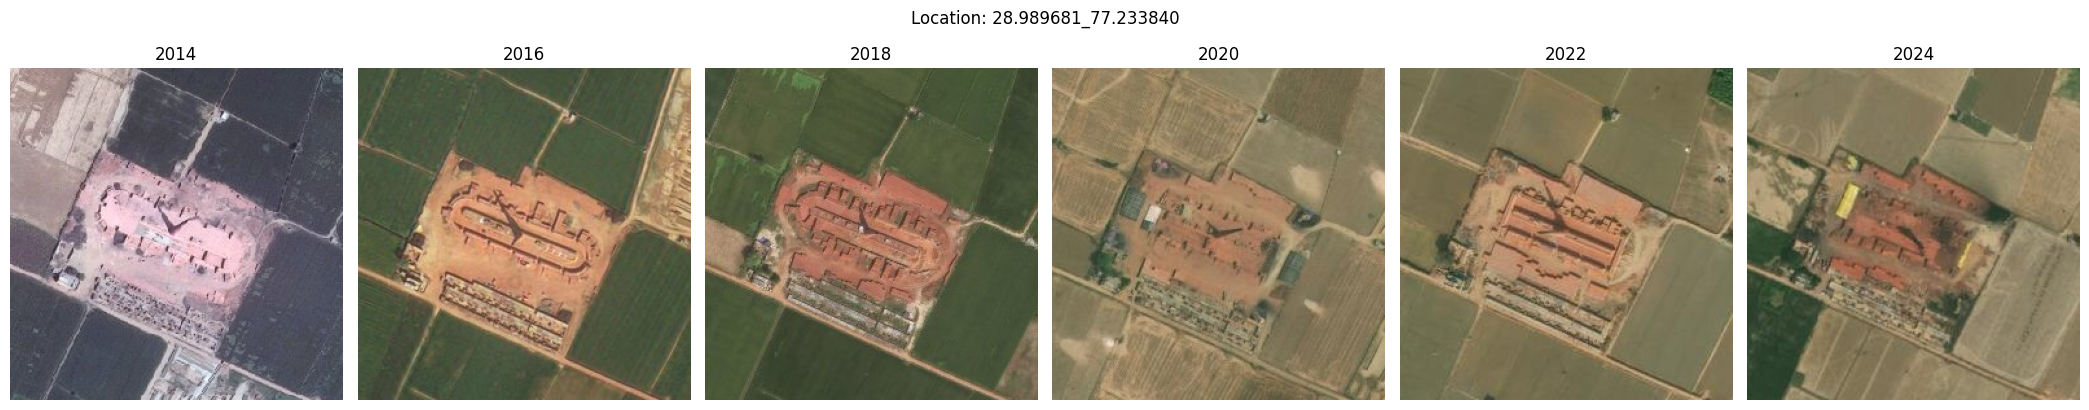

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

# -----------------------------
# CONFIG
# -----------------------------
USE_RANDOM = True        # True = random location, False = fixed
RANDOM_SEED = 4002         # set None for fully random

dirs = {
    2014: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2014_z_17_buf_25m"),
    2016: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2016_z_17_buf_25m"),
    2018: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2018_z_17_buf_25m"),
    2020: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2020_z_17_buf_25m"),
    2022: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2022_z_17_buf_25m"),
    2024: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2024_z_17_buf_25m"),
    2025: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m"),
}

# -----------------------------
# 1) collect lat_lon keys
# -----------------------------
year_to_keys = {}
for year, d in dirs.items():
    year_to_keys[year] = {
        "_".join(p.stem.split("_")[:2]) for p in d.glob("*.png")
    }

# -----------------------------
# 2) common locations
# -----------------------------
common_keys = set.intersection(*year_to_keys.values())
if not common_keys:
    raise RuntimeError("No common locations across all years")

# -----------------------------
# 3) choose location
# -----------------------------
if USE_RANDOM:
    if RANDOM_SEED is not None:
        random.seed(RANDOM_SEED)
    lat_lon = random.choice(list(common_keys))
else:
    lat_lon = sorted(common_keys)[0]

# -----------------------------
# 4) plot 1 × 6
# -----------------------------
fig, axes = plt.subplots(1, 6, figsize=(21, 4))

for ax, year in zip(axes, sorted(dirs)):
    img = Image.open(dirs[year] / f"{lat_lon}_{year}.png").convert("RGB")
    ax.imshow(img)
    ax.set_title(str(year))
    ax.axis("off")

plt.suptitle(f"Location: {lat_lon}", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
path="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi Brick Kiln - Sheet1 (2).csv"
df = pd.read_csv(path)
print(df.head(10))

   Unnamed: 0  Type       Lat       Lon  Year Made  Oval FCB to ZigZag  \
0           0     1  28.72475  76.92424     2012.0              2021.0   
1           1     1  28.92309  77.29121     2009.0              2019.0   
2           2     1  28.30281  77.35802     2010.0              2019.0   
3           3     1  28.20369  77.44003     2011.0              2019.0   
4           4     1  28.41146  77.61957     2009.0              2018.0   
5           5     1  28.98668  77.24535     2009.0              2019.0   
6           6     1  28.98768  77.24556     2009.0              2017.0   
7           7     1  28.79687  77.31316     2010.0              2018.0   
8           8     0  28.84369  77.42704     2010.0              2021.0   
9           9     1  28.84471  77.43415     2010.0              2021.0   

   Circular FCB to Zigzag  circular FCB to Oval FCB  ZigZag to FCB  \
0                     NaN                       NaN            NaN   
1                     NaN                    

## draw red border around the brick kilns

```html

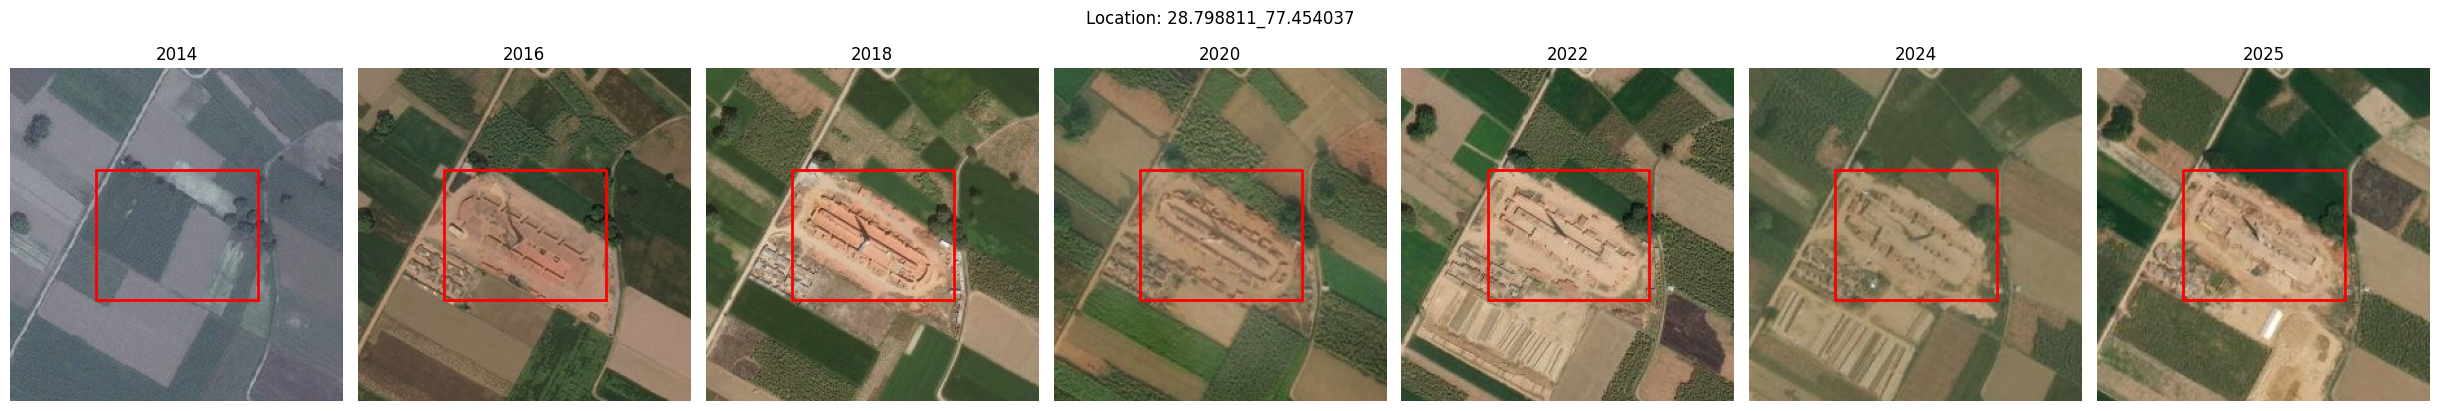

In [ ]:
import math
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random
import geopandas as gpd

# -----------------------------
# CONFIG
# -----------------------------
USE_RANDOM = True
RANDOM_SEED =  199

zoom = 17
tile_size = 256
buffer_m = 25
pad_tiles = 1

dirs = {
    2014: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2014_z_17_buf_25m"),
    2016: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2016_z_17_buf_25m"),
    2018: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2018_z_17_buf_25m"),
    2020: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2020_z_17_buf_25m"),
    2022: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2022_z_17_buf_25m"),
    2024: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2024_z_17_buf_25m"),
    2025: Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m"),
}

# -----------------------------
# Helpers (same projection math)
# -----------------------------
def lonlat_to_global_pixel(lon, lat, z, tile_size=256):
    n = 2.0 ** z
    x = (lon + 180.0) / 360.0 * n * tile_size
    lat_rad = math.radians(lat)
    y = (1.0 - math.log(math.tan(lat_rad) + 1.0 / math.cos(lat_rad)) / math.pi) / 2.0 * n * tile_size
    return x, y

def meters_per_pixel(lat_deg, z):
    return 156543.03392804097 * math.cos(math.radians(lat_deg)) / (2 ** z)

def crop_window_for_location(lon, lat, buffer_m, zoom, tile_size=256, pad_tiles=1):
    mpp = meters_per_pixel(lat, zoom)
    radius_px = int(math.ceil(buffer_m / mpp))
    crop_size = 2 * radius_px + 1
    crop_size = max(257, min(crop_size, 1025))

    gx, gy = lonlat_to_global_pixel(lon, lat, zoom, tile_size=tile_size)
    center_tile_x = int(gx // tile_size)
    center_tile_y = int(gy // tile_size)

    tiles_radius = int(math.ceil((crop_size / 2) / tile_size)) + pad_tiles
    x_min = center_tile_x - tiles_radius
    y_min = center_tile_y - tiles_radius

    origin_x = x_min * tile_size
    origin_y = y_min * tile_size

    px = int(round(gx - origin_x))
    py = int(round(gy - origin_y))

    W = (2 * tiles_radius + 1) * tile_size
    H = (2 * tiles_radius + 1) * tile_size

    half = crop_size // 2
    left = max(0, px - half)
    upper = max(0, py - half)
    right = min(W, left + crop_size)
    lower = min(H, upper + crop_size)
    left = max(0, right - crop_size)
    upper = max(0, lower - crop_size)

    # returns stitched-origin global pixels and crop top-left in stitched
    return crop_size, origin_x, origin_y, left, upper

def polygon_to_crop_pixels(poly, origin_x, origin_y, left, upper, zoom, tile_size=256):
    # returns list of (x,y) in crop pixel coordinates
    xs, ys = poly.exterior.coords.xy
    pts = []
    for lon, lat in zip(xs, ys):
        gx, gy = lonlat_to_global_pixel(lon, lat, zoom, tile_size=tile_size)
        sx = gx - origin_x
        sy = gy - origin_y
        cx = sx - left
        cy = sy - upper
        pts.append((cx, cy))
    return pts

# -----------------------------
# Pick one common location (lat_lon)
# -----------------------------
year_to_keys = {y: {"_".join(p.stem.split("_")[:2]) for p in d.glob("*.png")} for y, d in dirs.items()}
common_keys = set.intersection(*year_to_keys.values())
if not common_keys:
    raise RuntimeError("No common locations across all years")

if USE_RANDOM:
    if RANDOM_SEED is not None:
        random.seed(RANDOM_SEED)
    lat_lon = random.choice(list(common_keys))
else:
    lat_lon = sorted(common_keys)[0]

lat_str, lon_str = lat_lon.split("_")
lat0 = float(lat_str)
lon0 = float(lon_str)

# -----------------------------
# Get the kiln polygon from kilns_in_airshed for this lat_lon
# Assumes kilns_in_airshed has center_lat / center_lon columns (or compute them)
# -----------------------------
if "center_lat" not in kilns_in_airshed.columns or "center_lon" not in kilns_in_airshed.columns:
    tmp = kilns_in_airshed.copy()
    tmp = tmp.to_crs("EPSG:4326")
    tmp["center_lon"] = tmp.geometry.centroid.x
    tmp["center_lat"] = tmp.geometry.centroid.y
    kilns_in_airshed = tmp

# match by rounding to 6 decimals to align with filename precision
k = kilns_in_airshed.copy()
k["lat6"] = k["center_lat"].astype(float).round(6)
k["lon6"] = k["center_lon"].astype(float).round(6)

match = k[(k["lat6"] == round(lat0, 6)) & (k["lon6"] == round(lon0, 6))]
if match.empty:
    raise RuntimeError(f"No kiln polygon found in kilns_in_airshed for {lat_lon}")

poly = match.iloc[0].geometry

# -----------------------------
# Plot 1 × 6/7 with polygon overlay (red)
# -----------------------------
years = sorted(dirs.keys())
fig, axes = plt.subplots(1, len(years), figsize=(3.5 * len(years), 4))

if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    img_path = dirs[year] / f"{lat_lon}_{year}.png"
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)

    crop_size, origin_x, origin_y, left, upper = crop_window_for_location(
        lon0, lat0, buffer_m, zoom, tile_size=tile_size, pad_tiles=pad_tiles
    )

    pts = polygon_to_crop_pixels(poly, origin_x, origin_y, left, upper, zoom, tile_size=tile_size)
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    ax.plot(xs, ys, linewidth=2)   # default color; set to red below
    ax.lines[-1].set_color("red")

    ax.set_title(str(year))
    ax.axis("off")

plt.suptitle(f"Location: {lat_lon}", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
import os
import math
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import geopandas as gpd

# -----------------------------
# CONFIG
# -----------------------------
BASE_DIR = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data")
OUT_DIR  = BASE_DIR / "panels_with_polygon"
OUT_DIR.mkdir(parents=True, exist_ok=True)

USE_RANDOM = False          # keep False for full export
RANDOM_SEED = 199
MAX_LOCATIONS = None        # None = all, or set int for debugging

zoom = 17
tile_size = 256
buffer_m = 25
pad_tiles = 1

# years present
dirs = {
    2014: BASE_DIR / "delhi_airshed_y_2014_z_17_buf_25m",
    2016: BASE_DIR / "delhi_airshed_y_2016_z_17_buf_25m",
    2018: BASE_DIR / "delhi_airshed_y_2018_z_17_buf_25m",
    2020: BASE_DIR / "delhi_airshed_y_2020_z_17_buf_25m",
    2022: BASE_DIR / "delhi_airshed_y_2022_z_17_buf_25m",
    2024: BASE_DIR / "delhi_airshed_y_2024_z_17_buf_25m",
    2025: BASE_DIR / "delhi_airshed_y_2025_z_17_buf_25m",
}

# -----------------------------
# Helpers (same projection math)
# -----------------------------
def lonlat_to_global_pixel(lon, lat, z, tile_size=256):
    n = 2.0 ** z
    x = (lon + 180.0) / 360.0 * n * tile_size
    lat_rad = math.radians(lat)
    y = (1.0 - math.log(math.tan(lat_rad) + 1.0 / math.cos(lat_rad)) / math.pi) / 2.0 * n * tile_size
    return x, y

def meters_per_pixel(lat_deg, z):
    return 156543.03392804097 * math.cos(math.radians(lat_deg)) / (2 ** z)

def crop_window_for_location(lon, lat, buffer_m, zoom, tile_size=256, pad_tiles=1):
    mpp = meters_per_pixel(lat, zoom)
    radius_px = int(math.ceil(buffer_m / mpp))
    crop_size = 2 * radius_px + 1
    crop_size = max(257, min(crop_size, 1025))

    gx, gy = lonlat_to_global_pixel(lon, lat, zoom, tile_size=tile_size)
    center_tile_x = int(gx // tile_size)
    center_tile_y = int(gy // tile_size)

    tiles_radius = int(math.ceil((crop_size / 2) / tile_size)) + pad_tiles
    x_min = center_tile_x - tiles_radius
    y_min = center_tile_y - tiles_radius

    origin_x = x_min * tile_size
    origin_y = y_min * tile_size

    px = int(round(gx - origin_x))
    py = int(round(gy - origin_y))

    W = (2 * tiles_radius + 1) * tile_size
    H = (2 * tiles_radius + 1) * tile_size

    half = crop_size // 2
    left = max(0, px - half)
    upper = max(0, py - half)
    right = min(W, left + crop_size)
    lower = min(H, upper + crop_size)
    left = max(0, right - crop_size)
    upper = max(0, lower - crop_size)

    return crop_size, origin_x, origin_y, left, upper

def polygon_to_crop_pixels(poly, origin_x, origin_y, left, upper, zoom, tile_size=256):
    xs, ys = poly.exterior.coords.xy
    pts = []
    for lon, lat in zip(xs, ys):
        gx, gy = lonlat_to_global_pixel(lon, lat, zoom, tile_size=tile_size)
        sx = gx - origin_x
        sy = gy - origin_y
        pts.append((sx - left, sy - upper))
    return pts

# -----------------------------
# Prepare kiln polygons (needs kilns_in_airshed GeoDataFrame in memory)
# -----------------------------
if "center_lat" not in kilns_in_airshed.columns or "center_lon" not in kilns_in_airshed.columns:
    tmp = kilns_in_airshed.to_crs("EPSG:4326").copy()
    tmp["center_lon"] = tmp.geometry.centroid.x
    tmp["center_lat"] = tmp.geometry.centroid.y
    kilns_in_airshed = tmp

k = kilns_in_airshed.to_crs("EPSG:4326").copy()
k["lat6"] = k["center_lat"].astype(float).round(6)
k["lon6"] = k["center_lon"].astype(float).round(6)

poly_lookup = {(r.lat6, r.lon6): r.geometry for _, r in k.iterrows()}

# -----------------------------
# Collect common locations across years (lat_lon key)
# -----------------------------
year_to_keys = {}
for y, d in dirs.items():
    if not d.exists():
        raise FileNotFoundError(d)
    year_to_keys[y] = {"_".join(p.stem.split("_")[:2]) for p in d.glob("*.png")}

common_keys = set.intersection(*year_to_keys.values())
if not common_keys:
    raise RuntimeError("No common locations across all years")

keys = sorted(common_keys)

if USE_RANDOM:
    if RANDOM_SEED is not None:
        random.seed(RANDOM_SEED)
    random.shuffle(keys)

if MAX_LOCATIONS is not None:
    keys = keys[:MAX_LOCATIONS]

years = sorted(dirs.keys())

# -----------------------------
# Export panels for each location
# -----------------------------
saved = 0
skipped = 0

for lat_lon in keys:
    lat_str, lon_str = lat_lon.split("_")
    lat0 = float(lat_str)
    lon0 = float(lon_str)

    poly = poly_lookup.get((round(lat0, 6), round(lon0, 6)))
    if poly is None:
        skipped += 1
        continue

    fig, axes = plt.subplots(1, len(years), figsize=(3.5 * len(years), 4))
    if len(years) == 1:
        axes = [axes]

    ok = True
    for ax, year in zip(axes, years):
        img_path = dirs[year] / f"{lat_lon}_{year}.png"
        if not img_path.exists():
            ok = False
            break

        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)

        crop_size, origin_x, origin_y, left, upper = crop_window_for_location(
            lon0, lat0, buffer_m, zoom, tile_size=tile_size, pad_tiles=pad_tiles
        )
        pts = polygon_to_crop_pixels(poly, origin_x, origin_y, left, upper, zoom, tile_size=tile_size)
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        ax.plot(xs, ys, color="red", linewidth=2)

        ax.set_title(str(year))
        ax.axis("off")

    if not ok:
        plt.close(fig)
        skipped += 1
        continue

    fig.suptitle(f"Location: {lat_lon}", y=1.02)
    plt.tight_layout()

    out_path = OUT_DIR / f"{lat_lon}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    saved += 1

print("Saved panels:", saved)
print("Skipped:", skipped)
print("Output dir:", str(OUT_DIR))

Saved panels: 703
Skipped: 50
Output dir: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/panels_with_polygon


In [ ]:
import os
import math
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# ============================================================
# CONFIG
# ============================================================
BASE_DIR = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data")
OUT_DIR  = BASE_DIR / "panels_with_polygon"
OUT_DIR.mkdir(parents=True, exist_ok=True)

zoom = 17
tile_size = 256
buffer_m = 25
pad_tiles = 1

dirs = {
    2014: BASE_DIR / "delhi_airshed_y_2014_z_17_buf_25m",
    2016: BASE_DIR / "delhi_airshed_y_2016_z_17_buf_25m",
    2018: BASE_DIR / "delhi_airshed_y_2018_z_17_buf_25m",
    2020: BASE_DIR / "delhi_airshed_y_2020_z_17_buf_25m",
    2022: BASE_DIR / "delhi_airshed_y_2022_z_17_buf_25m",
    2024: BASE_DIR / "delhi_airshed_y_2024_z_17_buf_25m",
    2025: BASE_DIR / "delhi_airshed_y_2025_z_17_buf_25m",
}

years = sorted(dirs.keys())

# ============================================================
# PROJECTION HELPERS
# ============================================================
def lonlat_to_global_pixel(lon, lat, z, tile_size=256):
    n = 2.0 ** z
    x = (lon + 180.0) / 360.0 * n * tile_size
    lat_rad = math.radians(lat)
    y = (1.0 - math.log(math.tan(lat_rad) + 1 / math.cos(lat_rad)) / math.pi) / 2.0 * n * tile_size
    return x, y

def meters_per_pixel(lat_deg, z):
    return 156543.03392804097 * math.cos(math.radians(lat_deg)) / (2 ** z)

def crop_window_for_location(lon, lat):
    mpp = meters_per_pixel(lat, zoom)
    r_px = int(math.ceil(buffer_m / mpp))
    crop_size = max(257, min(2 * r_px + 1, 1025))

    gx, gy = lonlat_to_global_pixel(lon, lat, zoom)
    ct_x, ct_y = int(gx // tile_size), int(gy // tile_size)
    tr = int(math.ceil((crop_size / 2) / tile_size)) + pad_tiles

    origin_x = (ct_x - tr) * tile_size
    origin_y = (ct_y - tr) * tile_size

    px, py = int(gx - origin_x), int(gy - origin_y)
    half = crop_size // 2
    left = max(0, px - half)
    upper = max(0, py - half)

    return crop_size, origin_x, origin_y, left, upper

def polygon_to_crop_pixels(poly, origin_x, origin_y, left, upper):
    xs, ys = poly.exterior.coords.xy
    pts = []
    for lon, lat in zip(xs, ys):
        gx, gy = lonlat_to_global_pixel(lon, lat, zoom)
        pts.append((gx - origin_x - left, gy - origin_y - upper))
    return pts

# ============================================================
# LOAD KILN POLYGONS (NO CENTROID MATCHING)
# ============================================================
k = kilns_in_airshed.to_crs("EPSG:4326").copy()
k["center_lon"] = k.geometry.centroid.x
k["center_lat"] = k.geometry.centroid.y
sidx = k.sindex

# ============================================================
# COLLECT COMMON LOCATIONS (by filenames)
# ============================================================
year_to_keys = {
    y: {"_".join(p.stem.split("_")[:2]) for p in d.glob("*.png")}
    for y, d in dirs.items()
}

common_keys = sorted(set.intersection(*year_to_keys.values()))
print("Total candidate locations:", len(common_keys))

# ============================================================
# EXPORT PANELS
# ============================================================
saved = 0
skipped = []

for lat_lon in common_keys:
    lat0, lon0 = map(float, lat_lon.split("_"))

    # --- image availability check (ONLY SKIP REASON) ---
    missing_years = [
        y for y in years
        if not (dirs[y] / f"{lat_lon}_{y}.png").exists()
    ]
    if missing_years:
        skipped.append({
            "lat_lon": lat_lon,
            "reason": "missing_images",
            "years_missing": ",".join(map(str, missing_years))
        })
        continue

    # --- polygon selection: contain → nearest ---
    pt = Point(lon0, lat0)
    cand = k.iloc[list(sidx.intersection(pt.bounds))]
    hit = cand[cand.contains(pt)]
    if len(hit) > 0:
        poly = hit.iloc[0].geometry
    else:
        poly = cand.iloc[cand.distance(pt).idxmin()].geometry

    # --- plot ---
    fig, axes = plt.subplots(1, len(years), figsize=(3.5 * len(years), 4))
    for ax, year in zip(axes, years):
        img = Image.open(dirs[year] / f"{lat_lon}_{year}.png").convert("RGB")
        ax.imshow(img)

        crop_size, ox, oy, left, up = crop_window_for_location(lon0, lat0)
        pts = polygon_to_crop_pixels(poly, ox, oy, left, up)
        ax.plot([p[0] for p in pts], [p[1] for p in pts], color="red", linewidth=2)

        ax.set_title(str(year))
        ax.axis("off")

    fig.suptitle(f"Location: {lat_lon}", y=1.02)
    fig.savefig(OUT_DIR / f"{lat_lon}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)
    saved += 1

# ============================================================
# REPORT
# ============================================================
df_skip = pd.DataFrame(skipped)
df_skip.to_csv(OUT_DIR / "skipped_locations.csv", index=False)

print("Saved panels:", saved)
print("Skipped panels:", len(skipped))
print("Output dir:", OUT_DIR)

Total candidate locations: 753
Saved panels: 753
Skipped panels: 0
Output dir: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/panels_with_polygon


In [ ]:
import torch
from PIL import Image
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# -----------------------------
# CONFIG
# -----------------------------
model_id = "Qwen/Qwen3-VL-8B-Instruct"
panel_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/panels_with_polygon/28.212481_77.401398.png"

# The panel is 1 row with these years (left -> right)
years = [2014, 2016, 2018, 2020, 2022, 2024, 2025]

max_new_tokens = 1024

# -----------------------------
# LOAD MODEL
# -----------------------------
model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_id, dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_id)

# -----------------------------
# LOAD IMAGE
# -----------------------------
img = Image.open(panel_path).convert("RGB")

# -----------------------------
# PROMPT (appearance year in bbox / red outline area)
# -----------------------------
prompt = f"""
You are analyzing a temporal panel of satellite images of the SAME location.
The panel contains {len(years)} sub-images in ONE ROW (left to right) for years:
{years}.

Focus ONLY on the kiln area inside/along the red boundary (treat it as the bbox/ROI).
Ignore surroundings outside the red boundary.

Task:
1) Compare each year with the previous year within the ROI.
2) Identify the earliest year where a kiln structure (oval/rectangular; red/brown/gray kiln-like morphology) first appears in the ROI.
3) If no kiln appears in any year in the ROI, return "no kiln present".

Output STRICTLY as JSON:
{{
  "appearance_year": <year or "no kiln present">,
  "roi_state_by_year": {{
     "2014": "<present|absent|unclear>",
     ...
  }},
  "confidence": "<high|medium|low>"
}}

Rules:
- Use only visual evidence from the ROI.
- If uncertain, use "unclear" and lower confidence.
"""

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": prompt},
        ],
    }
]

# -----------------------------
# INFERENCE
# -----------------------------
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt",
)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.inference_mode():
    generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
]

out = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[0]

print(out)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/750 [00:00<?, ?it/s]

{
  "appearance_year": 2018,
  "roi_state_by_year": {
    "2014": "absent",
    "2016": "absent",
    "2018": "present",
    "2020": "present",
    "2022": "present",
    "2024": "present",
    "2025": "present"
  },
  "change_notes": [
    {
      "from": 2014,
      "to": 2016,
      "note": "ROI remains largely agricultural fields; no kiln structure visible."
    },
    {
      "from": 2016,
      "to": 2018,
      "note": "Kiln structure first appears in 2018, showing initial construction with visible outlines and earthworks."
    },
    {
      "from": 2018,
      "to": 2020,
      "note": "Kiln structure becomes more defined, with clearer rectangular/oval shapes and increased earth-moving activity."
    },
    {
      "from": 2020,
      "to": 2022,
      "note": "Kiln structure is more complete, with visible walls or foundations and minimal change in shape."
    },
    {
      "from": 2022,
      "to": 2024,
      "note": "Kiln structure appears largely unchanged, with possible 

In [ ]:
#   "change_notes": [
#      {{"from": 2014, "to": 2016, "note": "<what changed in ROI>"}}
#   ],

In [ ]:
import os
import re
import json
import torch
import pandas as pd
from pathlib import Path
from PIL import Image
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
import tqdm
# =========================
# CONFIG
# =========================
model_id = "Qwen/Qwen3-VL-8B-Instruct"

panels_dir = Path("/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/panels_with_polygon")
out_csv = "data/vlm_kiln_appearance_results.csv"

years = [2014, 2016, 2018, 2020, 2022, 2024, 2025]
max_new_tokens = 1024

# if you want to limit for testing, set e.g. 20, else None
limit = None

# =========================
# MODEL LOAD
# =========================
model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_id, dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_id)

# =========================
# PROMPT TEMPLATE
# =========================
PROMPT = f"""
You are analyzing a temporal panel of satellite images of the SAME location.
The panel contains {len(years)} sub-images in ONE ROW (left to right) for years:
{years}.

Focus ONLY on the kiln area inside/along the red boundary (treat it as the ROI).
Ignore surroundings outside the red boundary.

Task:
1) Compare each year with the previous year within the ROI.
2) Identify the earliest year where a kiln structure (oval/rectangular; red/brown/gray kiln-like morphology) first appears in the  at the location .
3) If no kiln appears in any year in the ROI, return "no kiln present".

Output STRICTLY as JSON:
{{
  "appearance_year": <year or "no kiln present">,
  "roi_state_by_year": {{
     "2014": "<present|absent|unclear>",
     "2016": "<present|absent|unclear>",
     "2018": "<present|absent|unclear>",
     "2020": "<present|absent|unclear>",
     "2022": "<present|absent|unclear>",
     "2024": "<present|absent|unclear>",
     "2025": "<present|absent|unclear>"
  }},
  "confidence": "<high|medium|low>"
}}

Rules:
Use only visual evidence from the ROI.
If uncertain, use "unclear" and lower confidence.
"""

# =========================
# JSON EXTRACTION (robust)
# =========================
def extract_json(text: str):
    text = text.strip()

    # try direct
    try:
        return json.loads(text)
    except Exception:
        pass

    # try first {...} block
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if m:
        cand = m.group(0)
        try:
            return json.loads(cand)
        except Exception:
            # minor cleanup attempts
            cand2 = cand.replace("\n", " ").strip()
            try:
                return json.loads(cand2)
            except Exception:
                return None
    return None

# =========================
# RUN ONE IMAGE
# =========================
def run_one(panel_path: Path):
    img = Image.open(panel_path).convert("RGB")

    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": PROMPT},
        ],
    }]

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)]
    out_text = processor.batch_decode(
        trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]

    data = extract_json(out_text)
    return out_text, data

# =========================
# MAIN LOOP
# =========================
panel_files = sorted(panels_dir.glob("*.png"))

if limit is not None:
    panel_files = panel_files[:limit]

rows = []
for p in tqdm.tqdm(panel_files):
    lat_lon = p.stem  # filename without .png

    try:
        raw, data = run_one(p)

        if data is None:
            rows.append({
                "lat_lon": lat_lon,
                "panel_path": str(p),
                "appearance_year": "",
                "confidence": "",
                "status": "parse_fail",
                "raw_output": raw
            })
            continue

        appearance_year = data.get("appearance_year", "")
        confidence = data.get("confidence", "")

        # flatten roi_state_by_year
        roi = data.get("roi_state_by_year", {}) or {}
        row = {
            "lat_lon": lat_lon,
            "panel_path": str(p),
            "appearance_year": appearance_year,
            "confidence": confidence,
            "status": "ok",
            "raw_output": raw
        }
        for y in years:
            row[f"roi_{y}"] = roi.get(str(y), "")

        # keep change notes as json string
        row["change_notes"] = json.dumps(data.get("change_notes", []), ensure_ascii=False)

        rows.append(row)

    except Exception as e:
        rows.append({
            "lat_lon": lat_lon,
            "panel_path": str(p),
            "appearance_year": "",
            "confidence": "",
            "status": "exception",
            "error": repr(e),
            "raw_output": ""
        })

df = pd.DataFrame(rows)
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)
print(df["status"].value_counts(dropna=False))

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 753/753 [1:22:20<00:00,  6.56s/it]

Saved: data/vlm_kiln_appearance_results.csv
ok    753
Name: status, dtype: int64


In [2]:
import pandas as pd
import numpy as np

path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/Delhi_Brick_Kiln_Final_Mapped.csv"
df = pd.read_csv(path)

# ensure numeric
df["Oval_FCB_to_ZigZag_Category"] = pd.to_numeric(
    df["Oval_FCB_to_ZigZag_Category"], errors="coerce"
)

# BEFORE technology
df["Tech_Before_Transition"] = np.where(
    df["Oval_FCB_to_ZigZag_Category"].notna(),
    "FCBK",
    "FCBK"   # no transition → always FCBK
)

# AFTER technology
df["Tech_After_Transition"] = np.where(
    df["Oval_FCB_to_ZigZag_Category"].notna(),
    "ZigZag",
    "FCBK"
)

df[
    [
        "Year_Made_Category",
        "Oval_FCB_to_ZigZag_Category",
        "Tech_Before_Transition",
        "Tech_After_Transition"
    ]
].head()

,Year_Made_Category,Oval_FCB_to_ZigZag_Category,Tech_Before_Transition,Tech_After_Transition
0,NaN,NaN,FCBK,FCBK
1,category_2014,NaN,FCBK,FCBK
2,category_2016,NaN,FCBK,FCBK
3,category_2014,NaN,FCBK,FCBK
4,category_2016,NaN,FCBK,FCBK
